In [7]:
# Import necessary modules
import numpy as np  # For grid and numerical operations
import random        # For random placement of items
import time          # To control simulation speed
from IPython.display import clear_output  # To visually update the board in notebooks

# TownBoard represents the simulation environment: the grid, roads, houses, tower, cars
class TownBoard:
    def __init__(self, size=20, num_houses=10):
        self.size = size
        self.num_houses = num_houses
        self.grid = np.zeros((size, size), dtype=int)  # 2D grid initialized to trees (0)
        
        # Define what each grid value represents
        self.cell_types = {
            0: {'name': 'tree', 'emoji': '🌲', 'flammable': True},
            1: {'name': 'house', 'emoji': '🏠', 'flammable': True},
            2: {'name': 'fire', 'emoji': '🔥', 'flammable': False},
            3: {'name': 'burned', 'emoji': '🪵', 'flammable': False},
            4: {'name': 'road', 'emoji': '⬜', 'flammable': False},
            5: {'name': 'tower', 'emoji': '🗼', 'flammable': False},
            6: {'name': 'car', 'emoji': '🚗', 'flammable': False},
            13: {'name':'tornado','emoji':'🌪️','flammable':False},
            14: {'name':'destroyed', 'emoji': '🪵', 'flammable': False}
        }

        # Simulation flags and tracking lists
        self.warning_active = False
        self.house_paths = []  # Path from house to road exit
        self.cars = []         # Active car agents
        self.car_times = []    # Time each car took to evacuate

    def generate_town(self):
        self.grid.fill(0)  # Fill grid with trees
        self._create_crossroads()  # Add main roads
        self.grid[1][1] = 5  # Place warning tower at top-left corner

        # Place houses and generate evacuation paths
        self.house_positions = []
        placed = 0
        while placed < self.num_houses:
            x, y = random.randint(1, self.size - 2), random.randint(1, self.size - 2)
            if self.grid[y][x] == 0:
                self.grid[y][x] = 1
                path = self._connect_to_cross(x, y)  # Connect house to road
                if path:
                    self.house_positions.append((x, y))
                    self.house_paths.append(path)
                    placed += 1

    def _create_crossroads(self):
        # Create T-shaped crossroad in center
        mid = self.size // 2
        for i in range(self.size):
            self.grid[mid][i] = 4  # Horizontal
            self.grid[i][mid] = 4  # Vertical

    def _connect_to_cross(self, x, y):
        # Create road path from a house at (x,y) to the nearest crossroad
        mid = self.size // 2
        path = []
        cx, cy = x, y

        # Move horizontally to center
        while cx != mid:
            cx += 1 if mid > cx else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        # Move vertically to center
        while cy != mid:
            cy += 1 if mid > cy else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        # From center, randomly pick an edge as the road exit
        exits = [(0, cy), (self.size - 1, cy), (cx, 0), (cx, self.size - 1)]
        ex, ey = random.choice(exits)

        # Extend road horizontally to edge
        while cx != ex:
            cx += 1 if ex > cx else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        # Extend road vertically to edge
        while cy != ey:
            cy += 1 if ey > cy else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        return path

    def assign_cars(self, _fire_positions):
        # Place cars on road tiles adjacent to houses and set their paths
        for path in self.house_paths:
            if not path:
                continue
            start = path[0]
            x, y = start
            self.cars.append([x, y, path[:], 0, 0])  # x, y, path, delay, steps

    def move_cars(self):
        updated_cars = []
        for x, y, path, delay, steps in self.cars:
            if delay > 0:
                updated_cars.append([x, y, path, delay - 1, steps + 1])
                continue
            self.grid[y][x] = 4  # Remove old car position
            if path:
                x, y = path.pop(0)
                if 0 <= x < self.size and 0 <= y < self.size:
                    self.grid[y][x] = 6  # Move car forward
                    updated_cars.append([x, y, path, 0, steps + 1])
            else:
                self.car_times.append(steps)  # Car finished
        self.cars = updated_cars

    def display(self):
        # Visual display of the simulation board with legend
        clear_output(wait=True)
        if self.warning_active:
            print("\n🚨 FOREST FIRE WARNING 🚨\n🚨 WEE-OO WEE-OO 🚨\n")
        for row in self.grid:
            print(' '.join(self.cell_types[cell]['emoji'] for cell in row))
        print("\nLegend: 🌲 Tree | 🏠 House | 🔥 Fire | 🪵 Burned | ⬜ Road | 🗼 Tower | 🚗 Car")


# FireSimulator handles fire spread logic and triggers evacuation
class FireSimulator:
    def __init__(self, board):
        self.board = board
        self.burning_cells = set()
        self.time_step = 0
        self.warning_triggered = False
        self.evacuated_reported = False

    def ignite_random(self, count=2):
        # Start fire at random flammable locations
        self.fire_origins = []
        for _ in range(count):
            while True:
                x, y = random.randint(0, self.board.size-1), random.randint(0, self.board.size-1)
                if self.board.grid[y][x] in [0, 1]:
                    self._ignite_cell(x, y)
                    self.fire_origins.append((x, y))
                    break

    def _ignite_cell(self, x, y):
        # Set a cell on fire and trigger car evacuation if first fire
        self.board.grid[y][x] = 2
        self.burning_cells.add((x, y))
        if not self.warning_triggered:
            self.board.warning_active = True
            self.board.assign_cars(self.fire_origins)
            self.warning_triggered = True

    def spread_fire(self):
        # Fire spread logic based on flammable neighbors
        new_fires = set()
        for (x, y) in self.burning_cells:
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.board.size and 0 <= ny < self.board.size:
                    target = self.board.grid[ny][nx]
                    if target in [0, 1] and random.random() < 0.6:
                        new_fires.add((nx, ny))
                    elif target == 4:  # Allow fire to jump across roads
                        jx, jy = nx + dx, ny + dy
                        if (0 <= jx < self.board.size and 0 <= jy < self.board.size and
                            self.board.grid[jy][jx] in [0, 1] and random.random() < 0.5):
                            new_fires.add((jx, jy))
        
        # Burn current cells
        for x, y in self.burning_cells:
            self.board.grid[y][x] = 3

        # Ignite new cells
        for x, y in new_fires:
            self._ignite_cell(x, y)

        self.burning_cells = new_fires
        self.time_step += 1
        return len(new_fires)

    def simulate(self, steps=50, delay=0.8, display=True):
        # Main simulation loop
        self.ignite_random()
        for _ in range(steps):
            if display==True:
                self.board.display()
                print(f"Time Step: {self.time_step} | Fires: {len(self.burning_cells)}")
            new_fires = self.spread_fire()
            self.board.move_cars()
            if display==True:
                print(f"New fires started: {new_fires}")
            time.sleep(delay)

            # Print evacuation report if all cars are done
            if not self.board.cars and not self.evacuated_reported and display==True:
                print("\n🚗 All vehicles evacuated!")
                for i, t in enumerate(self.board.car_times):
                    print(f"Car {i+1} evacuated in {t} minutes")
                if self.board.car_times:
                    print(f"Total evacuation time: {max(self.board.car_times)} minutes")
                self.evacuated_reported = True
                input("\nPress Enter to continue the simulation...")

        if display==True:
            if self.burning_cells:
                print("\n🔥 Fire still burning after full simulation.")
            else:
                print("\n🔥 Fire burned out!")

In [6]:
# Run the full simulation
town = TownBoard(size=20, num_houses=12)
town.generate_town()
sim = FireSimulator(town)
sim.simulate(steps=30, delay=0.5)


🚨 FOREST FIRE WARNING 🚨
🚨 WEE-OO WEE-OO 🚨

🌲 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🌲 🌲 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🪵 🗼 🪵 🪵 🪵 🪵 🪵 🪵 🌲 🪵 ⬜ 🌲 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ ⬜ ⬜ ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🌲 🪵 🪵 🪵
🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ ⬜ ⬜ 🪵 🪵 🪵 🌲 🪵 🪵 🪵
🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🪵 🪵 🪵 🪵 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🪵 🪵 🪵 🌲 🌲 🪵 🪵 🪵 ⬜ ⬜ 🪵 🪵 🪵 🪵 🌲 🪵 🪵 🪵 🪵
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🌲 🌲 🌲 🪵 🪵 🪵 🪵 🪵 🌲 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🌲 🌲 🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🌲 🌲 🪵 🪵 🪵 🪵 🪵 🪵 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🌲 🌲 🪵 🪵 🪵 🪵 🔥 🪵 🪵 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🌲 🌲 🪵 🔥 🪵 🔥 ⬜ ⬜ ⬜ ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🌲 🏠 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🏠 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🪵 🪵 🪵
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵 🪵

Legend: 🌲 Tree | 🏠 House | 🔥 Fire | 🪵 Burned | ⬜ Road | 🗼 Tower | 🚗 Car
Time Step: 29 | Fires: 3
New fires started: 1

🔥 Fire still burning after full simu

In [8]:
#Simulating 1000 times
evacuation_time=[]
for i in range(1000):
    town = TownBoard(20)
    town.generate_town()
    disaster = FireSimulator(town)
    disaster.simulate(steps=30, delay=0,display=False)
    evacuation_time.append(max(town.car_times))

In [9]:
times=0
for t in evacuation_time:
    times+=t
print(times/1000)

24.292


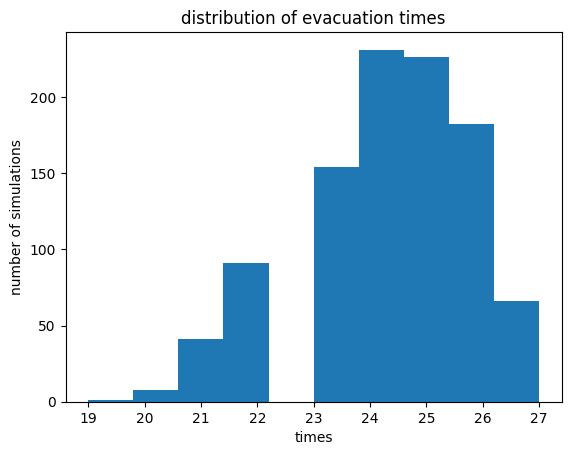

In [10]:
import matplotlib.pyplot as plt
plt.hist(evacuation_time)
plt.xlabel('times')
plt.ylabel('number of simulations')
plt.title('distribution of evacuation times');